## Introduction to Biometrics Project Code

Required Libraries
1. tsai
2. tensorflow
3. sklearn
4. pandas
5. numpy
6. matplotlib
7. seaborn

In [ ]:
!pip install tsai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 14.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

### Import Required Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
from tsai.all import *

### Load and Process Data

In [ ]:
# Read the CSV files
user1_files = [os.path.join('/content/drive/MyDrive/Biometrics/Dataset/User1', f) for f in os.listdir('/content/drive/MyDrive/Biometrics/Dataset/User1') if f.endswith('.CSV')]
user2_files = [os.path.join('/content/drive/MyDrive/Biometrics/Dataset/User2', f) for f in os.listdir('/content/drive/MyDrive/Biometrics/Dataset/User2') if f.endswith('.CSV')]
user3_files = [os.path.join('/content/drive/MyDrive/Biometrics/Dataset/User3', f) for f in os.listdir('/content/drive/MyDrive/Biometrics/Dataset/User3') if f.endswith('.CSV')]
user4_files = [os.path.join('/content/drive/MyDrive/Biometrics/Dataset/User4', f) for f in os.listdir('/content/drive/MyDrive/Biometrics/Dataset/User4') if f.endswith('.CSV')]
user5_files = [os.path.join('/content/drive/MyDrive/Biometrics/Dataset/User5', f) for f in os.listdir('/content/drive/MyDrive/Biometrics/Dataset/User5') if f.endswith('.CSV')]

In [ ]:
# Preprocess the data and create time series
time_series = []
labels = []

def process_files(files, label, timeseries_length=500):
    """
    Process the CSV files for a user and create time series data.

    Args:
        files (list): List of file paths for a user.
        label (int): Label for the user.
        timeseries_length (int): Length of each time series segment.
    """
    count = 0
    for file in files:
        try:
            data = pd.read_csv(file)
        except pd.errors.ParserError:
            print(f"Skipping file {file} due to inconsistent columns.")

        data = data.drop('button', axis=1)
        data = data.drop('state', axis=1)
        data = data.sort_values('client timestamp')
        data = data.drop('client timestamp', axis=1)

        num_series = len(data) // timeseries_length
        count += num_series
        if count > 2500: break
        for i in range(num_series):
            start_idx = i * timeseries_length
            end_idx = start_idx + timeseries_length
            time_series.append(data.iloc[start_idx:end_idx].values)
            labels.append(label)

# Process files for each user
process_files(user1_files, 0)
process_files(user2_files, 1)
process_files(user3_files, 2)
process_files(user4_files, 3)
process_files(user5_files, 4)

In [ ]:
from collections import Counter

# Print the count of labels for each user
print(Counter(labels))

Counter({0: 2455, 3: 2123, 4: 1993, 1: 1742, 2: 1065})


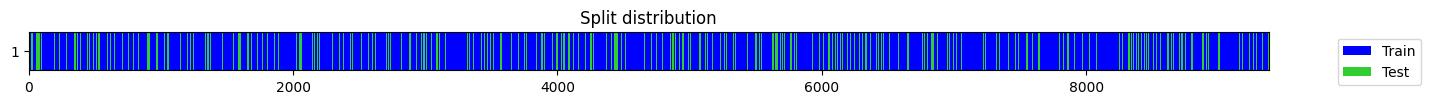

In [ ]:
# Prepare the data for the tsai model
max_length = 500

X = np.array(time_series, dtype=np.float32)
y = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine and get splits index for tsai
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

# Create data splits for training and validation
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=True)
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)


### Train using InceptionTime Model
---
InceptionTime is a deep learning architecture for time series classification implemented in the tsai library. The original InceptionTime model proposed by Fawaz et al. in 2019.

  1. InceptionTime is an ensemble of 5 deep CNN models inspired by the Inception-v4 architecture.
  2. Each CNN has the same structure but starts with different random weights.
  3. The core component is the Inception module, which applies convolutional filters of various lengths (e.g. 10, 20, 40) in parallel to the input time series to automatically learn relevant features at different time scales.
  4. Inception modules contain a bottleneck layer for dimensionality reduction, parallel convolutions, max pooling, and concatenation of outputs.
  5. Multiple Inception modules are stacked to create a deep network, with early modules learning local features and later modules capturing high-level patterns.
  6. Residual shortcut connections between modules are included but have limited impact on accuracy.
  7. The receptive field size depends on the filter lengths and number of stacked Inception modules. Longer filters tend to improve accuracy more than adding layers.



In [ ]:
# Create data loaders for training and validation
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

In [ ]:
# Create the InceptionTime model
save_best_model = SaveModel(monitor='valid_loss', comp=np.less, fname='best_model')
model = InceptionTime(dls.vars, dls.c)

print(model)

InceptionTime(
  (inceptionblock): InceptionBlock(
    (inception): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(500, 32, kernel_size=(1,), stride=(1,), bias=False)
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxconvpool): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(500, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (concat): Concat(dim=1)
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (1-5): 5 x InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
        (convs): ModuleList

In [ ]:
# Create a learner and fit the model
learn = Learner(dls, model, metrics=accuracy)
learn.add_cb(save_best_model)

learn.fit_one_cycle(30, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.029755,0.920956,0.648000,00:03
1,0.889542,0.854348,0.673600,00:02
2,0.858148,0.832124,0.670933,00:03
3,0.830063,0.825326,0.680533,00:02
4,0.832544,0.843419,0.675200,00:02
5,0.822583,0.819450,0.690133,00:02
6,0.817663,0.791361,0.693867,00:02
7,0.806931,0.796624,0.685867,00:05
8,0.787364,0.769866,0.706133,00:03
9,0.758924,0.781025,0.698667,00:02


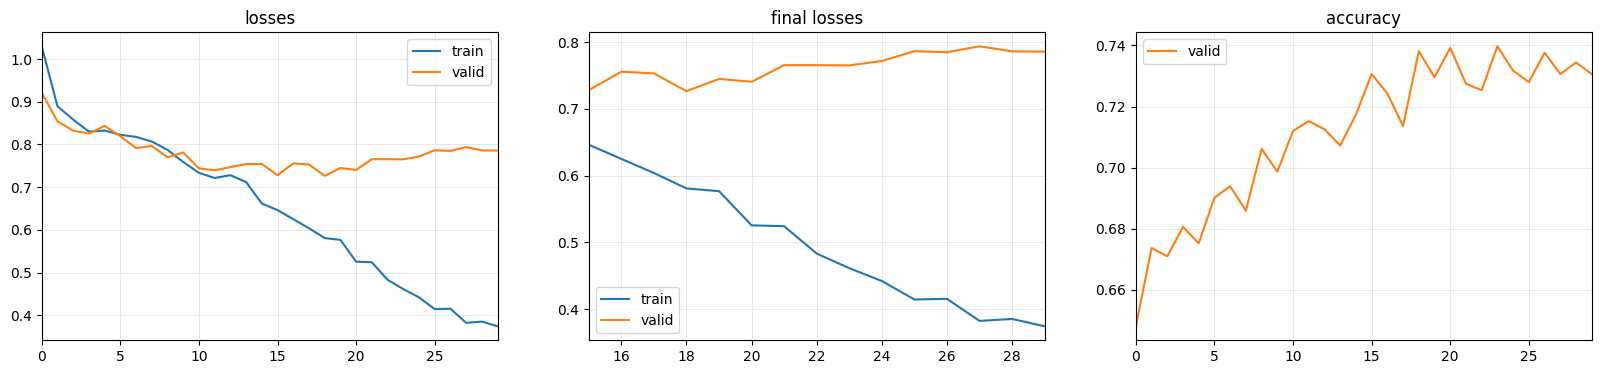

In [ ]:
# Plot the training metrics
learn.recorder.plot_metrics()

In [ ]:
learn.load('best_model')

In [ ]:
# Validate the model and print the validation loss and accuracy
valid_loss, valid_acc = learn.validate()
print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")


Validation Loss: 0.7265, Validation Accuracy: 0.7381


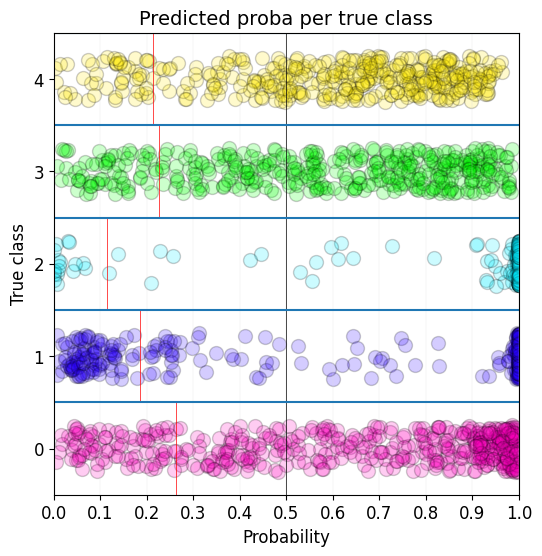

In [ ]:
# Show the predicted probabilities for each class
learn.show_probas()

## Quality Measures

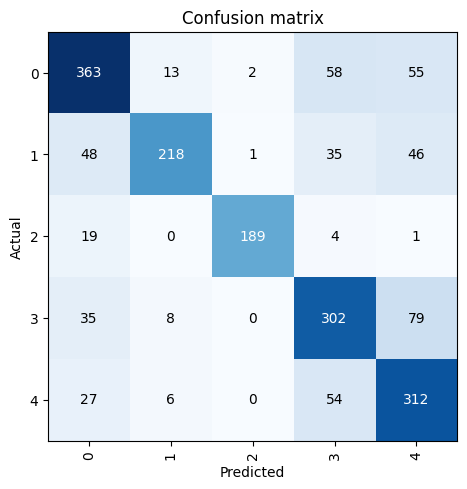

In [ ]:
# Create a classification interpretation object
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# Print the confusion matrix
interp.confusion_matrix()

array([[363,  13,   2,  58,  55],
       [ 48, 218,   1,  35,  46],
       [ 19,   0, 189,   4,   1],
       [ 35,   8,   0, 302,  79],
       [ 27,   6,   0,  54, 312]])

In [ ]:
def calculate_metrics(confusion_matrix):
    """
    Calculate various metrics from the confusion matrix.

    Args:
        confusion_matrix (numpy.ndarray): Confusion matrix.

    Returns:
        dict: Dictionary containing metrics for each class.
    """
    num_classes = confusion_matrix.shape[0]
    metrics = {}

    for class_idx in range(num_classes):
        tp = confusion_matrix[class_idx, class_idx]
        fp = np.sum(confusion_matrix[:, class_idx]) - tp
        fn = np.sum(confusion_matrix[class_idx, :]) - tp
        tn = np.sum(confusion_matrix) - tp - fp - fn

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        tpr = tp / (tp + fn) if tp + fn > 0 else 0
        tnr = tn / (tn + fp) if tn + fp > 0 else 0
        fpr = fp / (fp + tn) if fp + tn > 0 else 0
        fnr = fn / (fn + tp) if fn + tp > 0 else 0

        metrics[f'Class_{class_idx}'] = {
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'True Positive Rate (TPR)': tpr,
            'True Negative Rate (TNR)': tnr,
            'False Positive Rate (FPR)': fpr,
            'False Negative Rate (FNR)': fnr
        }

    return metrics

In [ ]:
# Calculate metrics from the confusion matrix
metrics = calculate_metrics(interp.confusion_matrix())
for class_name, class_metrics in metrics.items():
    print(f"{class_name}:")
    for metric_name, metric_value in class_metrics.items():
        print(f"  {metric_name}: {metric_value:.3f}")

Class_0:
  Precision: 0.738
  Recall: 0.739
  F1 Score: 0.739
  True Positive Rate (TPR): 0.739
  True Negative Rate (TNR): 0.907
  False Positive Rate (FPR): 0.093
  False Negative Rate (FNR): 0.261
Class_1:
  Precision: 0.890
  Recall: 0.626
  F1 Score: 0.735
  True Positive Rate (TPR): 0.626
  True Negative Rate (TNR): 0.982
  False Positive Rate (FPR): 0.018
  False Negative Rate (FNR): 0.374
Class_2:
  Precision: 0.984
  Recall: 0.887
  F1 Score: 0.933
  True Positive Rate (TPR): 0.887
  True Negative Rate (TNR): 0.998
  False Positive Rate (FPR): 0.002
  False Negative Rate (FNR): 0.113
Class_3:
  Precision: 0.667
  Recall: 0.712
  F1 Score: 0.689
  True Positive Rate (TPR): 0.712
  True Negative Rate (TNR): 0.896
  False Positive Rate (FPR): 0.104
  False Negative Rate (FNR): 0.288
Class_4:
  Precision: 0.633
  Recall: 0.782
  F1 Score: 0.700
  True Positive Rate (TPR): 0.782
  True Negative Rate (TNR): 0.877
  False Positive Rate (FPR): 0.123
  False Negative Rate (FNR): 0.218


From the report we can see that despite low accuracy it has very low False Positive Rate for all the classes. This metric is very important for this mouse dynamics based user verification. Imagine this is used in an online examination. If someone else logins instead of examinee and attemps to cheat, then low FPR is essential as even if it is False Negative then it can be easily verified, perhaps by checking the webcam footage. But it is not possible to check everyone's webcam footage all the time.

### Train using Model Xception Time Plus

Variant of Inception Time

In [ ]:
 # Create the InceptionTimePlus model
 model = XceptionTimePlus(dls.vars, dls.c)

 print(model)

XceptionTimePlus(
  (backbone): XceptionBlockPlus(
    (xception): ModuleList(
      (0): XceptionModulePlus(
        (bottleneck): ConvBlock(
          (0): Conv1d(500, 16, kernel_size=(1,), stride=(1,), bias=False)
        )
        (convs): ModuleList(
          (0): ConvBlock(
            (0): SeparableConv1d(
              (depthwise_conv): Conv1d(16, 16, kernel_size=(39,), stride=(1,), padding=(19,), groups=16, bias=False)
              (pointwise_conv): Conv1d(16, 16, kernel_size=(1,), stride=(1,), bias=False)
            )
          )
          (1): ConvBlock(
            (0): SeparableConv1d(
              (depthwise_conv): Conv1d(16, 16, kernel_size=(19,), stride=(1,), padding=(9,), groups=16, bias=False)
              (pointwise_conv): Conv1d(16, 16, kernel_size=(1,), stride=(1,), bias=False)
            )
          )
          (2): ConvBlock(
            (0): SeparableConv1d(
              (depthwise_conv): Conv1d(16, 16, kernel_size=(9,), stride=(1,), padding=(4,), groups=

In [ ]:
# Create a learner and fit the model
learn = Learner(dls, model, metrics=accuracy)
learn.add_cb(save_best_model)

learn.fit_one_cycle(30, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.213955,1.154403,0.607467,00:02
1,1.103892,1.038160,0.658133,00:02
2,1.031192,0.984925,0.673067,00:02
3,0.990734,0.951019,0.677867,00:03
4,0.962298,0.940323,0.675733,00:02
5,0.931762,0.920048,0.681067,00:02
6,0.901716,0.889904,0.681600,00:03
7,0.873454,0.867501,0.686400,00:02
8,0.855442,0.860309,0.702933,00:03
9,0.837543,0.816653,0.721067,00:02


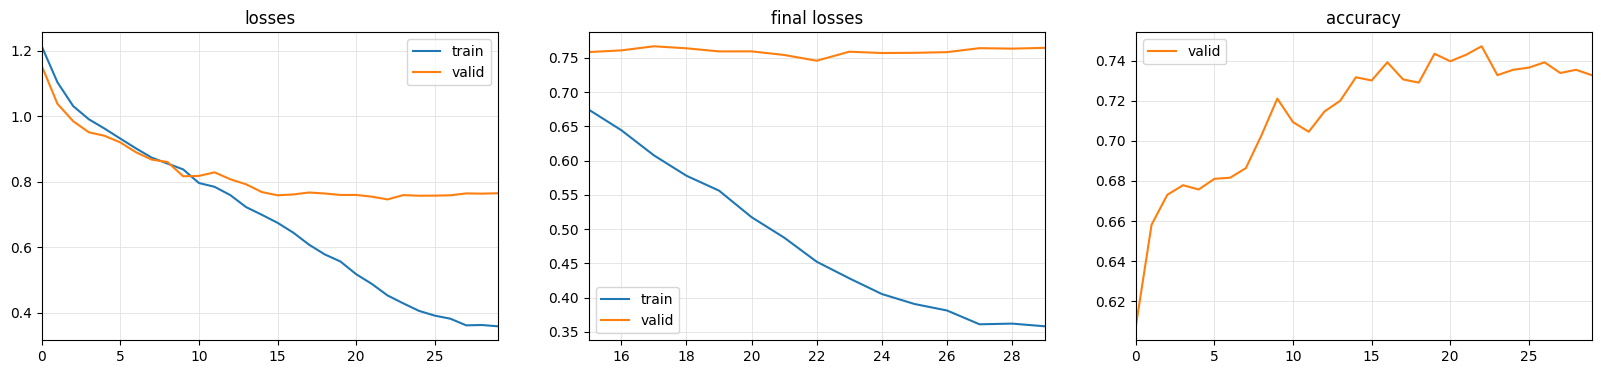

In [ ]:
# Plot the training metrics
learn.recorder.plot_metrics()

In [ ]:
learn.load('best_model')

In [ ]:
# Validate the model and print the validation loss and accuracy
valid_loss, valid_acc = learn.validate()
print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")


Validation Loss: 0.7459, Validation Accuracy: 0.7472


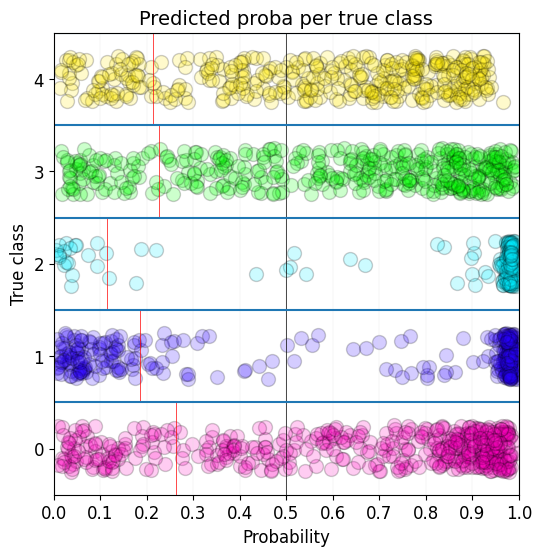

In [ ]:
# Show the predicted probabilities for each class
learn.show_probas()

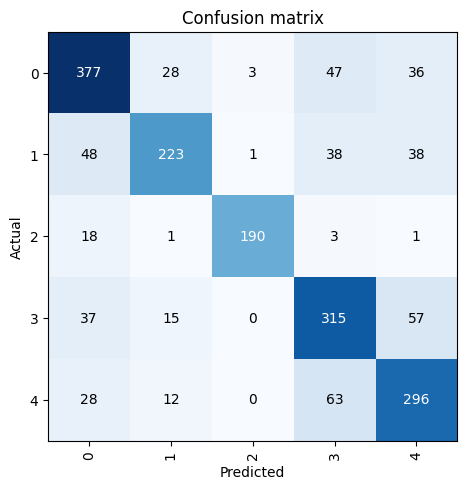

In [ ]:
# Create a classification interpretation object
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# Calculate metrics from the confusion matrix
metrics = calculate_metrics(interp.confusion_matrix())
for class_name, class_metrics in metrics.items():
    print(f"{class_name}:")
    for metric_name, metric_value in class_metrics.items():
        print(f"  {metric_name}: {metric_value:.3f}")

Class_0:
  Precision: 0.742
  Recall: 0.768
  F1 Score: 0.755
  True Positive Rate (TPR): 0.768
  True Negative Rate (TNR): 0.905
  False Positive Rate (FPR): 0.095
  False Negative Rate (FNR): 0.232
Class_1:
  Precision: 0.799
  Recall: 0.641
  F1 Score: 0.711
  True Positive Rate (TPR): 0.641
  True Negative Rate (TNR): 0.963
  False Positive Rate (FPR): 0.037
  False Negative Rate (FNR): 0.359
Class_2:
  Precision: 0.979
  Recall: 0.892
  F1 Score: 0.934
  True Positive Rate (TPR): 0.892
  True Negative Rate (TNR): 0.998
  False Positive Rate (FPR): 0.002
  False Negative Rate (FNR): 0.108
Class_3:
  Precision: 0.676
  Recall: 0.743
  F1 Score: 0.708
  True Positive Rate (TPR): 0.743
  True Negative Rate (TNR): 0.896
  False Positive Rate (FPR): 0.104
  False Negative Rate (FNR): 0.257
Class_4:
  Precision: 0.692
  Recall: 0.742
  F1 Score: 0.716
  True Positive Rate (TPR): 0.742
  True Negative Rate (TNR): 0.911
  False Positive Rate (FPR): 0.089
  False Negative Rate (FNR): 0.258


### Train using LSTM_FCNPlus Model

In [ ]:
# Create the LSTM_FCNPlus model
model = LSTM_FCNPlus(
    dls.vars, dls.c,
    hidden_size=128, # number of hidden units in LSTM layers
    rnn_layers=2,    # number of stacked LSTM layers
    bias=True,       # use bias in LSTM layers
    cell_dropout=0,  # dropout for LSTM cells
    rnn_dropout=0.2, # dropout between LSTM layers
    bidirectional=True,  # use bidirectional LSTM
    shuffle=False,    # shuffle features in FCN part
    fc_dropout=0.0,  # dropout in FCN part
    conv_layers=[128, 256, 128],  # convolutional layers config in FCN
    kss=[7, 5, 3],   # kernel sizes for conv layers in FCN
    se=0             # squeeze-excitation ratio in FCN
)

print(model)

LSTM_FCNPlus(
  (backbone): _RNN_FCN_Base_Backbone(
    (rnn): LSTM(500, 128, num_layers=2, batch_first=True, bidirectional=True)
    (rnn_dropout): Dropout(p=0.2, inplace=False)
    (shuffle): Permute(dims=0, 2, 1)
    (convblock1): ConvBlock(
      (0): Conv1d(500, 128, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock2): ConvBlock(
      (0): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock3): ConvBlock(
      (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (gap): GAP1d(
      (gap): AdaptiveAvgPool1d(output_size=1)
      (flatten): Reshape(bs)
 

In [ ]:
# Create a learner and fit the model
learn = Learner(dls, model, metrics=accuracy)
learn.add_cb(save_best_model)

learn.fit_one_cycle(30, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.128319,1.020776,0.618133,00:01
1,0.942338,0.883806,0.651733,00:01
2,0.869811,0.838417,0.674667,00:01
3,0.851265,0.820011,0.670933,00:01
4,0.812089,0.808179,0.683200,00:01
5,0.807713,0.802140,0.691200,00:01
6,0.780553,0.805490,0.685333,00:01
7,0.753106,0.775476,0.697600,00:01
8,0.711876,0.776892,0.705600,00:01
9,0.690956,0.791685,0.693333,00:01


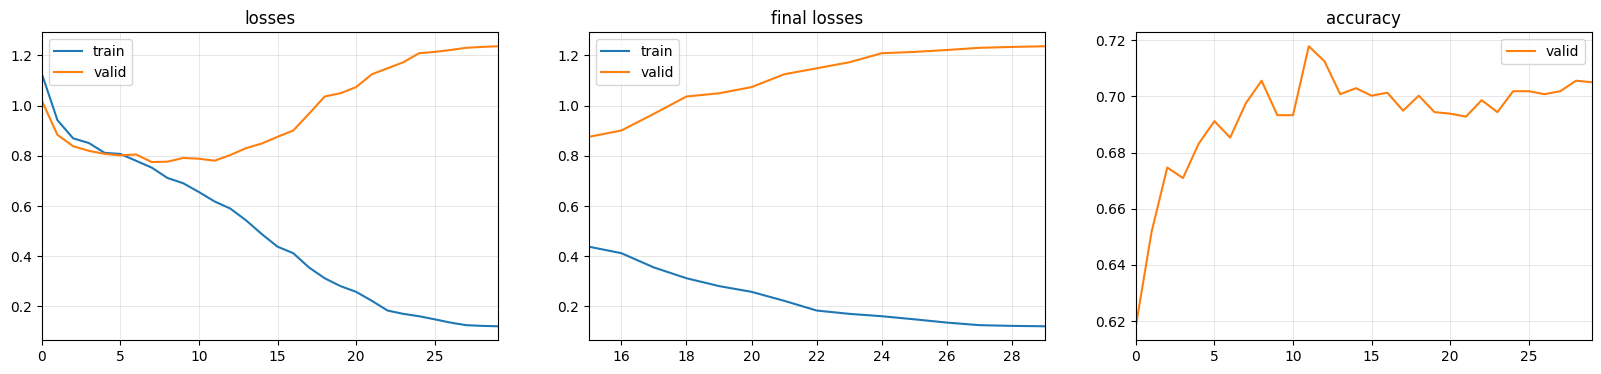

In [ ]:
# Plot the training metrics
learn.recorder.plot_metrics()

In [ ]:
learn.load('best_model')

In [ ]:
# Validate the model and print the validation loss and accuracy
valid_loss, valid_acc = learn.validate()
print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

Validation Loss: 0.7755, Validation Accuracy: 0.6976


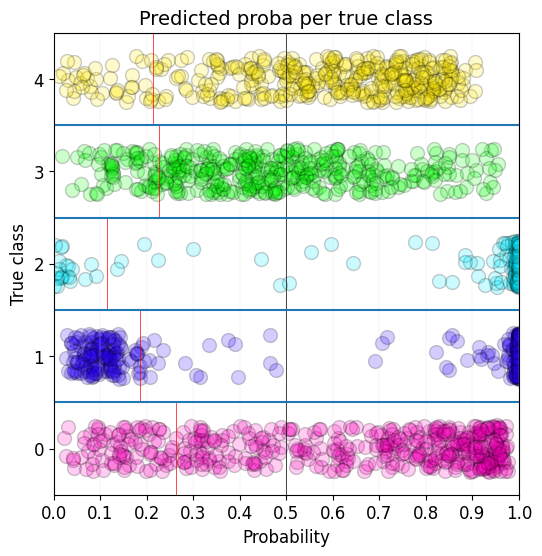

In [ ]:
# Show the predicted probabilities for each class
learn.show_probas()

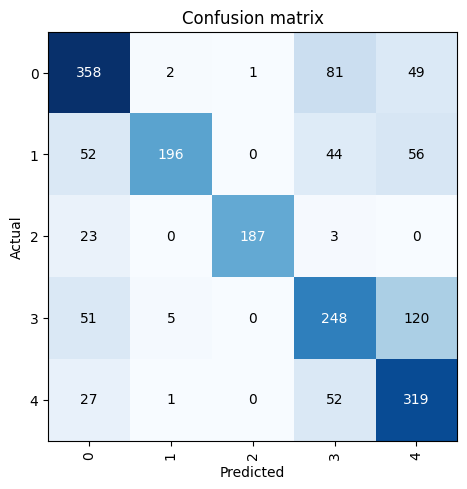

In [ ]:
# Create a classification interpretation object
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# Calculate metrics from the confusion matrix
metrics = calculate_metrics(interp.confusion_matrix())
for class_name, class_metrics in metrics.items():
    print(f"{class_name}:")
    for metric_name, metric_value in class_metrics.items():
        print(f"  {metric_name}: {metric_value:.3f}")

Class_0:
  Precision: 0.701
  Recall: 0.729
  F1 Score: 0.715
  True Positive Rate (TPR): 0.729
  True Negative Rate (TNR): 0.889
  False Positive Rate (FPR): 0.111
  False Negative Rate (FNR): 0.271
Class_1:
  Precision: 0.961
  Recall: 0.563
  F1 Score: 0.710
  True Positive Rate (TPR): 0.563
  True Negative Rate (TNR): 0.995
  False Positive Rate (FPR): 0.005
  False Negative Rate (FNR): 0.437
Class_2:
  Precision: 0.995
  Recall: 0.878
  F1 Score: 0.933
  True Positive Rate (TPR): 0.878
  True Negative Rate (TNR): 0.999
  False Positive Rate (FPR): 0.001
  False Negative Rate (FNR): 0.122
Class_3:
  Precision: 0.579
  Recall: 0.585
  F1 Score: 0.582
  True Positive Rate (TPR): 0.585
  True Negative Rate (TNR): 0.876
  False Positive Rate (FPR): 0.124
  False Negative Rate (FNR): 0.415
Class_4:
  Precision: 0.586
  Recall: 0.799
  F1 Score: 0.677
  True Positive Rate (TPR): 0.799
  True Negative Rate (TNR): 0.848
  False Positive Rate (FPR): 0.152
  False Negative Rate (FNR): 0.201


### Train using LSTM Based Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, SpatialDropout1D, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten

import tensorflow.keras as keras

In [ ]:
timeseries_length = 500
num_features = 2  # Number of variables in the time series data
num_classes = 5  # Number of unique users

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timeseries_length, num_features)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))),
    Dropout(0.2),
    BatchNormalization(),

    Bidirectional(LSTM(64, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))),
    Dropout(0.2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.5),
    BatchNormalization(),

    Dense(num_classes, activation='softmax', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 498, 64)           448       
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 249, 64)           0         
 ng1D)                                                           
                                                                 
 batch_normalization_34 (Ba  (None, 249, 64)           256       
 tchNormalization)                                               
                                                                 
 conv1d_20 (Conv1D)          (None, 247, 128)          24704     
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 123, 128)          0         
 ng1D)                                                           
                                                     

In [ ]:
# Convert target labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [ ]:
# Create a ModelCheckpoint callback
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model with the ModelCheckpoint callback
history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=25,
          validation_data=(X_test, y_test),
          callbacks=[checkpoint_callback])

Epoch 1/25
233/235 [============================>.] - ETA: 0s - loss: 1.5277 - accuracy: 0.5526
Epoch 1: val_accuracy improved from -inf to 0.63166, saving model to best_model.h5
235/235 [==============================] - 72s 260ms/step - loss: 1.5259 - accuracy: 0.5528 - val_loss: 1.2778 - val_accuracy: 0.6317
Epoch 2/25
235/235 [==============================] - ETA: 0s - loss: 1.3118 - accuracy: 0.6293
Epoch 2: val_accuracy improved from 0.63166 to 0.69136, saving model to best_model.h5
235/235 [==============================] - 8s 32ms/step - loss: 1.3118 - accuracy: 0.6293 - val_loss: 1.1407 - val_accuracy: 0.6914
Epoch 3/25
234/235 [============================>.] - ETA: 0s - loss: 1.2435 - accuracy: 0.6418
Epoch 3: val_accuracy did not improve from 0.69136
235/235 [==============================] - 6s 25ms/step - loss: 1.2435 - accuracy: 0.6420 - val_loss: 1.4397 - val_accuracy: 0.5864
Epoch 4/25
235/235 [==============================] - ETA: 0s - loss: 1.2139 - accuracy: 0.659

In [ ]:
# Load the best model weights
model.load_weights('best_model.h5')

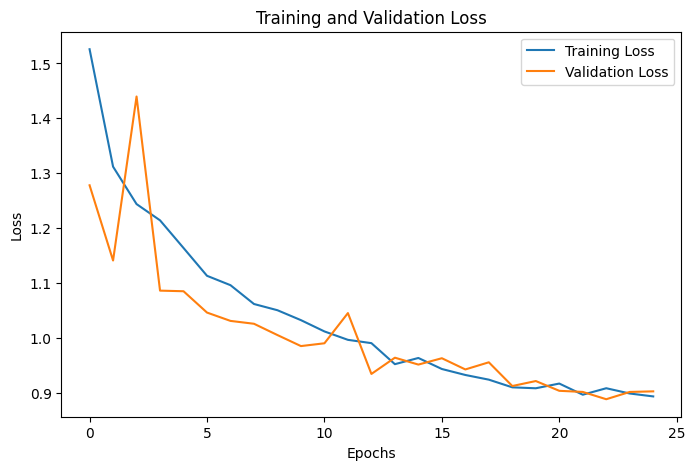

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

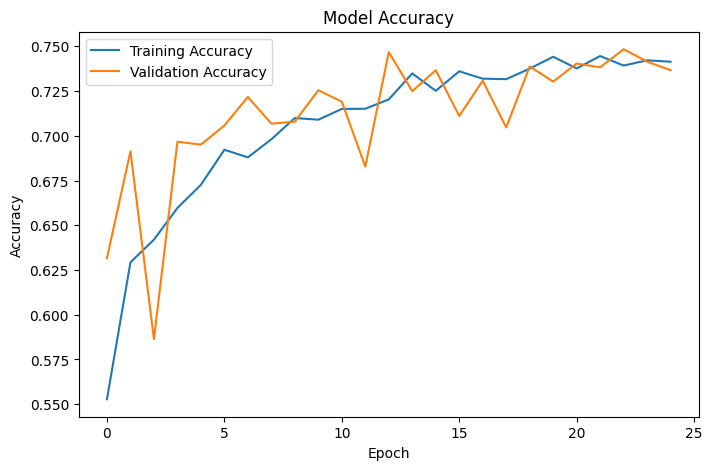

In [ ]:
# Plot the accuracy of each epoch
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Predict classes on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

59/59 [==============================] - 3s 10ms/step


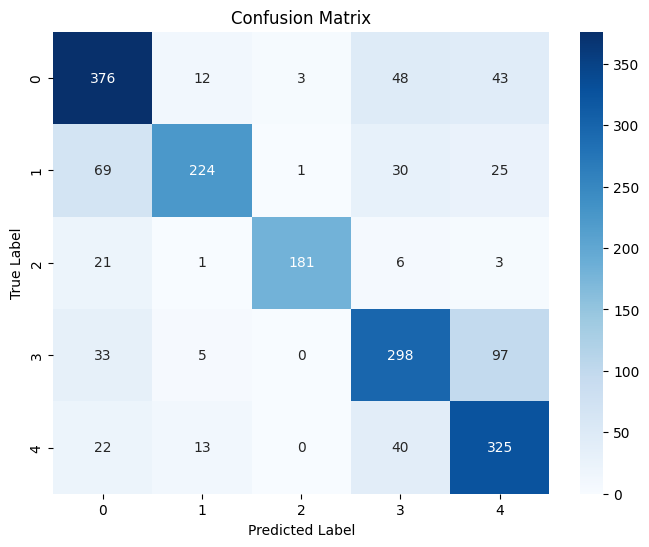

In [ ]:
# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Calculate metrics from the confusion matrix
metrics = calculate_metrics(cm)
for class_name, class_metrics in metrics.items():
    print(f"{class_name}:")
    for metric_name, metric_value in class_metrics.items():
        print(f"  {metric_name}: {metric_value:.3f}")

Class_0:
  Precision: 0.722
  Recall: 0.780
  F1 Score: 0.750
  True Positive Rate (TPR): 0.780
  True Negative Rate (TNR): 0.896
  False Positive Rate (FPR): 0.104
  False Negative Rate (FNR): 0.220
Class_1:
  Precision: 0.878
  Recall: 0.642
  F1 Score: 0.742
  True Positive Rate (TPR): 0.642
  True Negative Rate (TNR): 0.980
  False Positive Rate (FPR): 0.020
  False Negative Rate (FNR): 0.358
Class_2:
  Precision: 0.978
  Recall: 0.854
  F1 Score: 0.912
  True Positive Rate (TPR): 0.854
  True Negative Rate (TNR): 0.998
  False Positive Rate (FPR): 0.002
  False Negative Rate (FNR): 0.146
Class_3:
  Precision: 0.706
  Recall: 0.688
  F1 Score: 0.697
  True Positive Rate (TPR): 0.688
  True Negative Rate (TNR): 0.914
  False Positive Rate (FPR): 0.086
  False Negative Rate (FNR): 0.312
Class_4:
  Precision: 0.659
  Recall: 0.812
  F1 Score: 0.728
  True Positive Rate (TPR): 0.812
  True Negative Rate (TNR): 0.886
  False Positive Rate (FPR): 0.114
  False Negative Rate (FNR): 0.188
